# Assessing supernova detection thresholds using MCMC and optimization

In this notebook, we will create a synthetic supernova signal and run an MCMC fit to assess the thresholds of "recovery".  We will compare the result of an optimization fit to the results of the MCMC fit.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

Text(0.5,1,'EPIC 220381074')

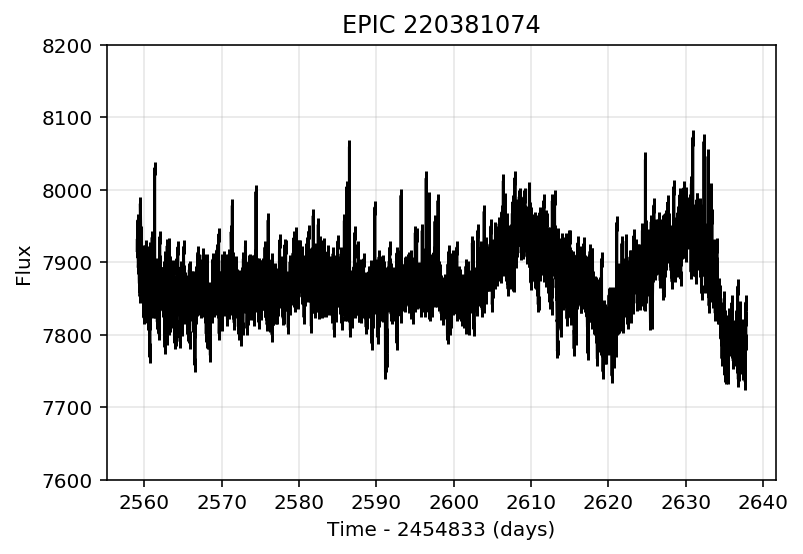

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

In [4]:
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

In [5]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=8.e-8)

In [6]:
lcinj = lc.inject(model)

Text(0,0.5,'Flux')

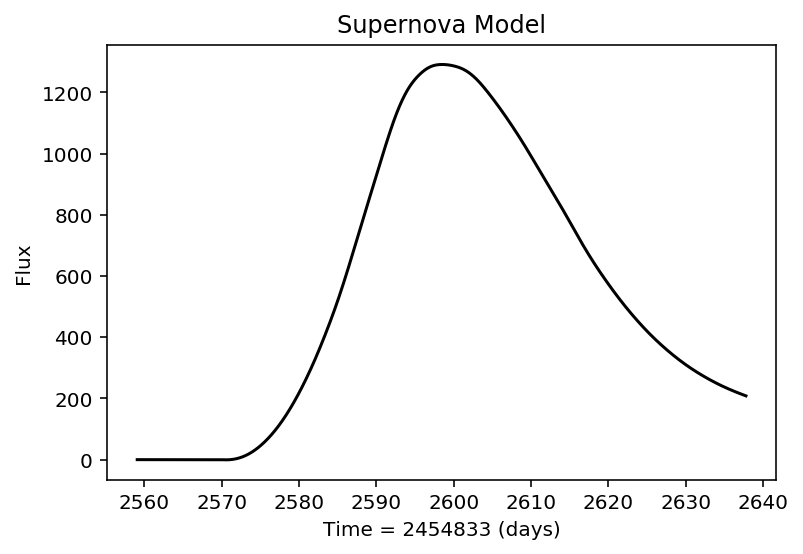

In [7]:
model_sn_eval = model.evaluate(lc.time)

plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

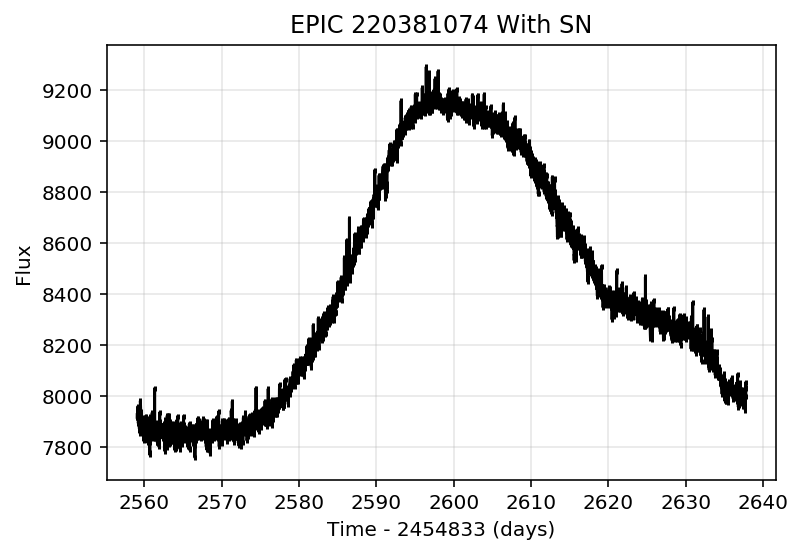

In [8]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

In [10]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [15]:
%%time
sampler, x = lcinj.recover('Supernova', method='mcmc', nwalkers=8, nsteps=1000, initial_guess=x0, threads=4)
samples = sampler.chain

np.save('/Users/sheilasagear/supernovae/supernova_sampler.npy', samples)



CPU times: user 26min 40s, sys: 2min 32s, total: 29min 13s
Wall time: 15min 33s


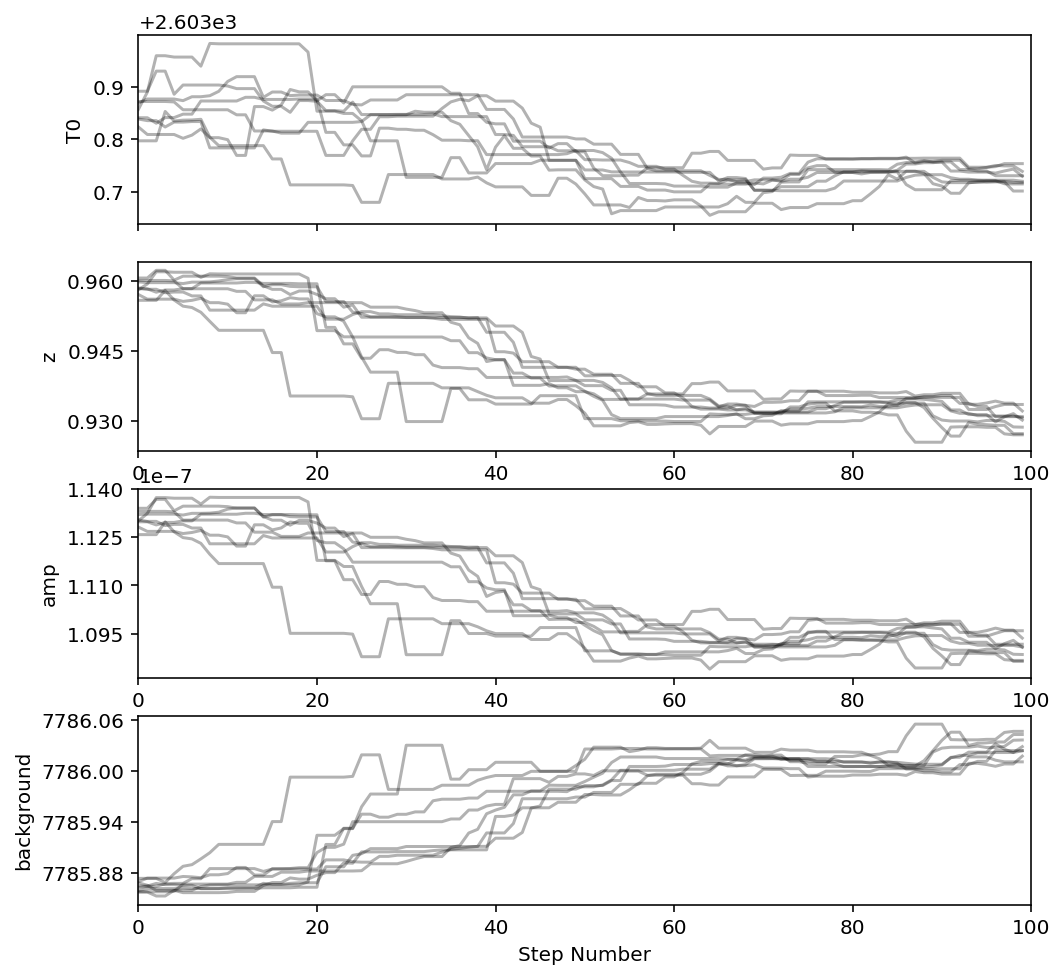

In [26]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp', 'background']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 900:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 100)
fig1.show()

In [20]:
sampler.chain.shape

(8, 1000, 4)

In [22]:
import corner

In [28]:
samples.shape

(160, 4)

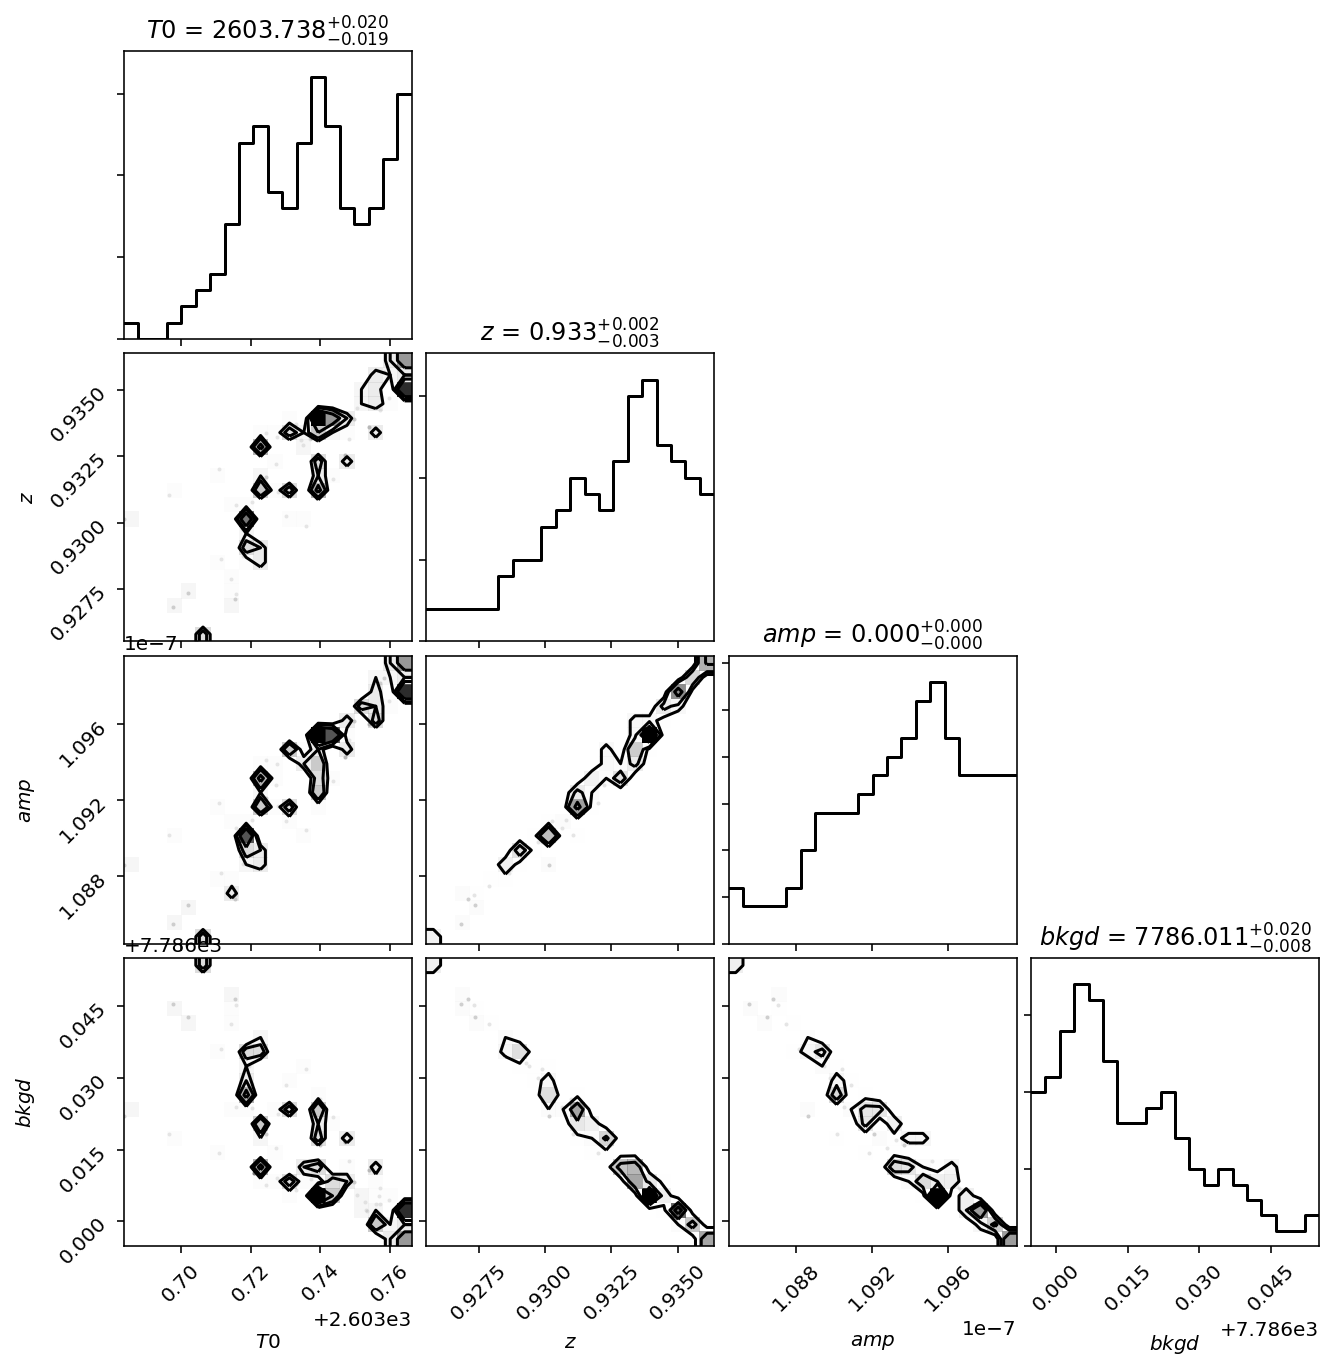

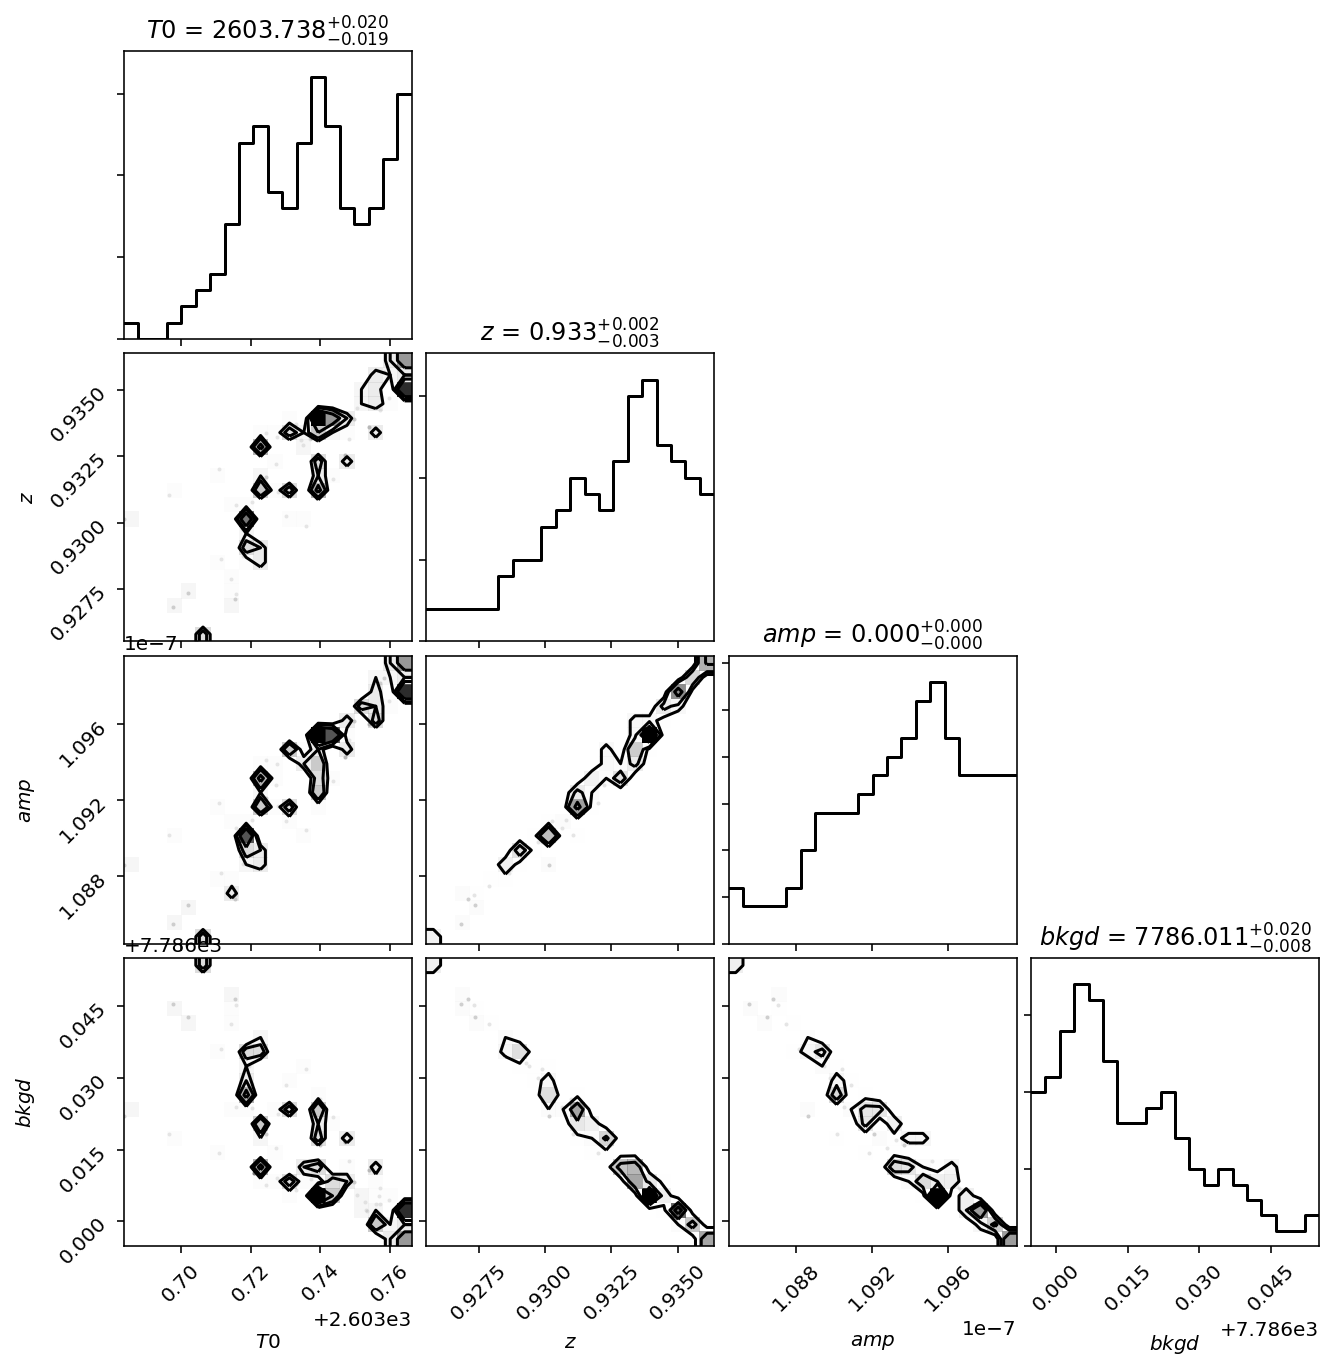

In [27]:
samples = sampler.chain[:, 980:, :].reshape((-1, 4))

corner.corner(samples[:], labels=["$T0$", "$z$", "$amp$", '$bkgd$'], smooth1d=True,
             show_titles=True, max_n_ticks=5,title_fmt='.3f',color='k')

In [37]:
params = samples[np.random.randint(0,20)]
params

array([2.60374005e+03, 9.30963870e-01, 1.09198521e-07, 7.78602554e+03])

In [41]:
fitted_model = inj.SupernovaModel(T0=params[0], z=params[1], amplitude=params[2], source='hsiao', bandpass='kepler')





In [42]:
fit_lc = fitted_model.evaluate(lcinj.time) + params[3]

In [50]:
model_sn_eval = model.evaluate(lc.time) + np.percentile(lc.flux, 3)

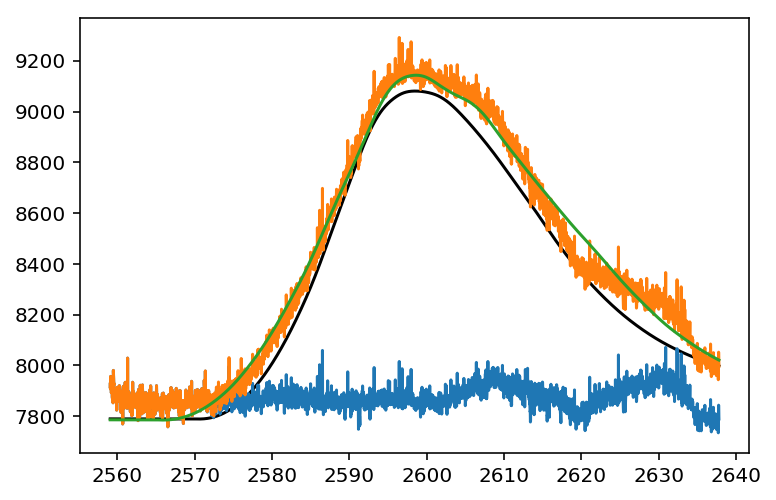

In [52]:
plt.plot(lc.time, model_sn_eval, c='k')
plt.plot(lc.time, lc.flux)
plt.plot(lcinj.time, lcinj.flux)
plt.plot(lcinj.time, fit_lc)

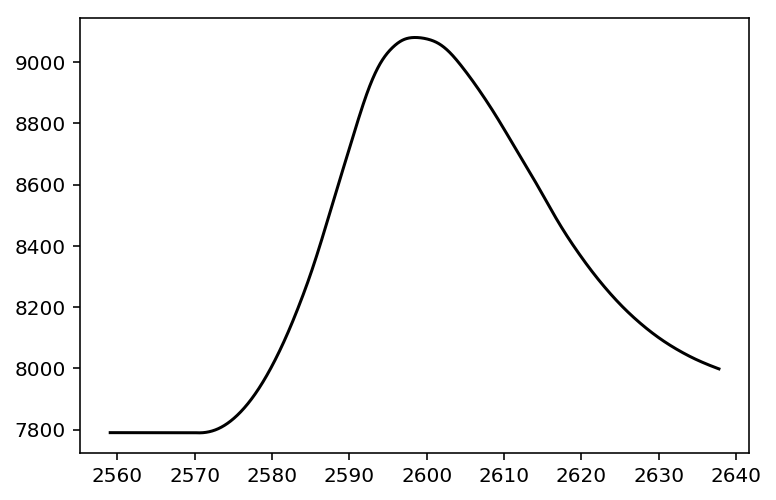

In [49]:
model_sn_eval = model.evaluate(lc.time) + np.percentile(lc.flux, 3)

plt.plot(lc.time, model_sn_eval, c='k')